In [1]:
import numpy as np
import torch
from torch import nn, optim
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms, models

In [2]:
imsize = 224

loader = transforms.Compose([
    transforms.Resize(imsize), 
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [3]:
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image

In [4]:
content_img = image_loader("images/landscape.jpg")
style_img = image_loader("images/monet.jpg")

In [5]:
unloader = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225)),
    transforms.ToPILImage()])

In [6]:
def tensor2image(tensor):
    image = tensor.clone() 
    image = image.squeeze(0)  
    image = unloader(image)
    return image

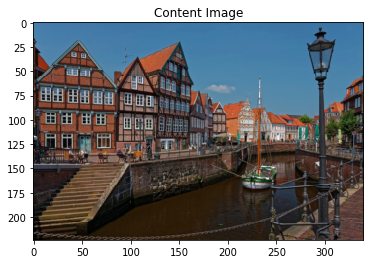

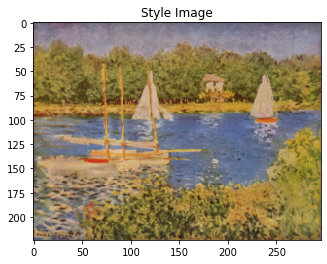

In [7]:
plt.figure()
plt.imshow(tensor2image(content_img))
plt.title("Content Image")
plt.show()

plt.figure()
plt.imshow(tensor2image(style_img))
plt.title("Style Image")
plt.show()

In [8]:
model = models.vgg19(pretrained=True).features

for param in model.parameters():
    param.requires_grad_(False)

In [9]:
relevant_layers = {'0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1', '19': 'conv4_1', '21': 'conv4_2', '28': 'conv5_1'}

In [10]:
def features_extractor(x, model, layers):
        
    features = {}
    for index, layer in model._modules.items():
        x = layer(x)
        if index in layers:
            features[layers[index]] = x
            
    return features

In [11]:
content_features = features_extractor(content_img, model, relevant_layers)
style_features = features_extractor(style_img, model, relevant_layers)

In [12]:
style_grams = {}
for i in style_features:
    layer = style_features[i]
    _, d1, d2, d3 = layer.shape
    features = layer.view(d1, d2 * d3)
    gram = torch.mm(features, features.t())
    style_grams[i] = gram

In [13]:
target_img = content_img.clone().requires_grad_(True)

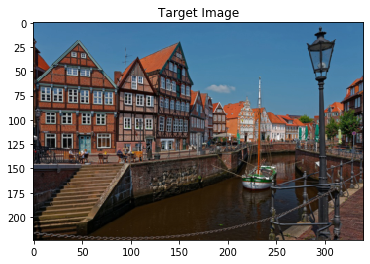

In [14]:
plt.figure()
plt.imshow(tensor2image(target_img))
plt.title("Target Image")
plt.show()

In [15]:
style_weights = {'conv1_1': 1., 'conv2_1': 0.8, 'conv3_1': 0.6, 'conv4_1': 0.4, 'conv5_1': 0.2}

In [16]:
alpha = 1
beta = 1e5

In [17]:
print_statement = 500
optimizer = torch.optim.Adam([target_img], lr=0.001)
iterations = 5000

Total loss:  28781662.0


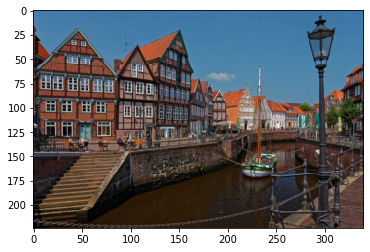

Total loss:  1932032.75


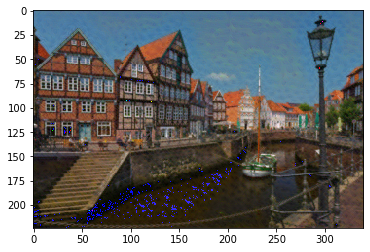

Total loss:  897534.3125


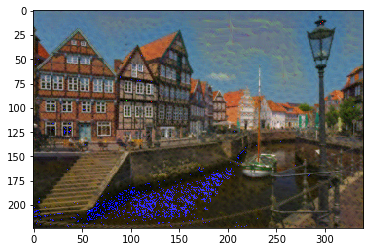

Total loss:  542568.5625


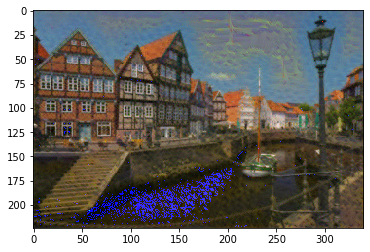

Total loss:  376501.46875


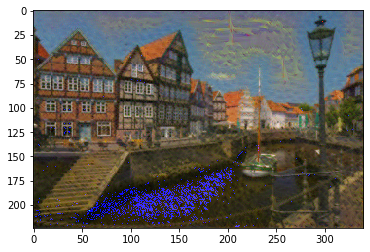

Total loss:  282741.59375


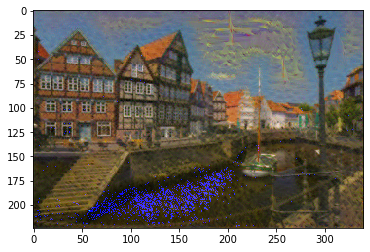

Total loss:  222263.359375


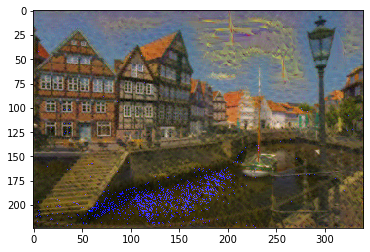

Total loss:  178824.765625


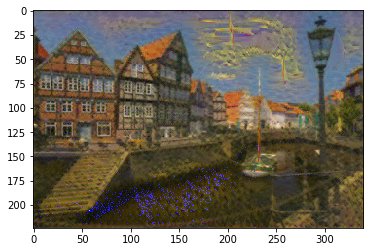

Total loss:  145290.46875


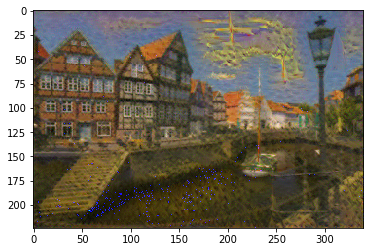

Total loss:  117932.890625


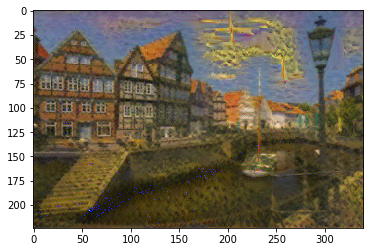

Total loss:  95140.3515625


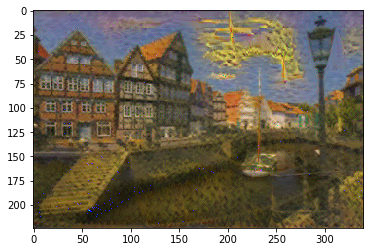

In [18]:
for i in range(1, iterations+1):
    
    target_features = features_extractor(target_img, model, relevant_layers)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    style_losses = 0
    for layer in style_weights:
        
        target_feature = target_features[layer]
        _, d1, d2, d3 = target_feature.shape
        
        target_reshaped = target_feature.view(d1, d2 * d3)
        target_gram = torch.mm(target_reshaped, target_reshaped.t())
        style_gram = style_grams[layer]
                
        style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_losses += style_loss / (d1 * d2 * d3)
        
    total_loss = alpha * content_loss + beta * style_losses
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if  i % print_statement == 0 or i == 1:
        print('Total loss: ', total_loss.item())
        plt.imshow(tensor2image(target_img))
        plt.show()

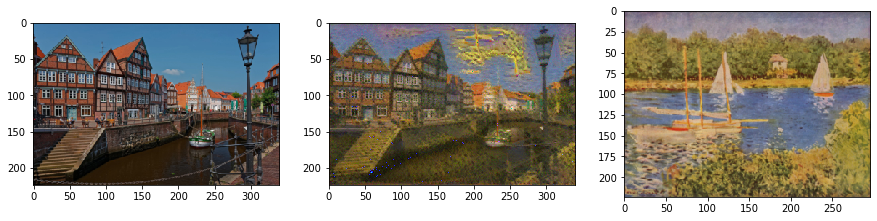

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.imshow(tensor2image(content_img))
ax2.imshow(tensor2image(target_img))
ax3.imshow(tensor2image(style_img))
plt.show()